In [1]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores

from apa_utils import load_apa_data, load_apa_predictor, animate_apa_examples


Using TensorFlow backend.


In [2]:
#Load APA data and predictor

encoder = OneHotEncoder(seq_length=205, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

data_path = '../analysis/apa/apa_doubledope_cached_set.pickle'

x_train, y_train, x_test, y_test = load_apa_data(data_path, encoder)

predictor_path = '../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'

predictor = load_apa_predictor(predictor_path)


len(data_df) = 34748 (loaded)
x_train.shape = (32992, 1, 205, 4)
x_test.shape = (1728, 1, 205, 4)
y_train.shape = (32992, 1)
y_test.shape = (1728, 1)


In [3]:
#Define sequence template and background

sequence_template = 'CTTCCGATCT$$$$$$$$$$$$$$$$$$$$CATTACTCGCATCCA$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$CAGCCAATTAAGCC$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$CTAC'

pseudo_count = 1.0

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)


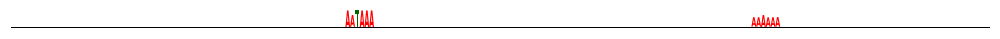

In [4]:
#Visualize background sequence distribution

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=205)


In [5]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.8729476983107292


In [6]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 3,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : True,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=205,
    n_out_channels=4,
    input_templates=[onehot_template],
    input_backgrounds=[x_mean],
    batch_size=32,
    n_samples=32,
    sample_mode='st',
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config
)


In [7]:
#Train scrambler

n_epochs = 10

train_history = scrambler.train(
    predictor,
    x_train,
    y_train,
    x_test,
    y_test,
    n_epochs,
    monitor_test_indices=np.arange(32).tolist(),
    monitor_batch_freq_dict={0 : 1, 100 : 5, 1031 : 10},
    nll_mode='reconstruction',
    predictor_task='classification_sym',
    entropy_mode='target',
    entropy_bits=0.25,
    entropy_weight=1.
)


Train on 32992 samples, validate on 1728 samples
Epoch 1/10
32992/32992 [==============================] - 185s 6ms/step - loss: 0.4543 - nll_loss: 0.4180 - entropy_loss: 0.0363 - val_loss: 0.3806 - val_nll_loss: 0.3577 - val_entropy_loss: 0.0229
Epoch 2/10
32992/32992 [==============================] - 160s 5ms/step - loss: 0.3571 - nll_loss: 0.3317 - entropy_loss: 0.0253 - val_loss: 0.3398 - val_nll_loss: 0.2756 - val_entropy_loss: 0.0643
Epoch 3/10
32992/32992 [==============================] - 160s 5ms/step - loss: 0.3241 - nll_loss: 0.3034 - entropy_loss: 0.0207 - val_loss: 0.3294 - val_nll_loss: 0.3139 - val_entropy_loss: 0.0155
Epoch 4/10
32992/32992 [==============================] - 160s 5ms/step - loss: 0.3025 - nll_loss: 0.2845 - entropy_loss: 0.0180 - val_loss: 0.3062 - val_nll_loss: 0.2910 - val_entropy_loss: 0.0153
Epoch 5/10
32992/32992 [==============================] - 160s 5ms/step - loss: 0.2870 - nll_loss: 0.2709 - entropy_loss: 0.0161 - val_loss: 0.2959 - val_nll_l

In [8]:
#Save scrambler checkpoint
save_dir = 'saved_models'

model_name = 'apa_inclusion_scrambler_smooth_target_bits_025_epochs_10_deeper'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.save_model(model_path)

pickle.dump({'train_history' : train_history}, open(save_dir + '/' + model_name + '_train_history.pickle', 'wb'))


Saved scrambler model at saved_models/apa_inclusion_scrambler_smooth_target_bits_025_epochs_10_deeper.h5 


In [7]:
#Load models
save_dir = 'saved_models'

model_name = 'apa_inclusion_scrambler_smooth_target_bits_025_epochs_10_deeper'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.load_model(model_path)


Loaded scrambler model from saved_models/apa_inclusion_scrambler_smooth_target_bits_025_epochs_10_deeper.h5 


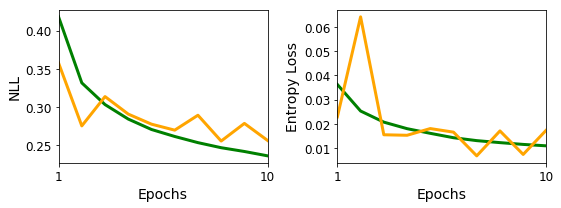

In [10]:
#Plot training statistics

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [8]:
#Interpret the test set using the trained scrambler

pwm_test, sample_test, importance_scores_test = scrambler.interpret(x_test)


1728/1728 [==============================] - 4s 2ms/step


Test sequence 0:
 - Prediction (original) = 0.09
 - Predictions (scrambled) = [0.04, 0.02, 0.13, 0.19, 0.07, 0.14, 0.06, 0.03, 0.19, 0.07, 0.13, 0.1, 0.02, 0.06, 0.09, 0.23, 0.02, 0.09, 0.01, 0.03, 0.16, 0.04, 0.04, 0.2, 0.02, 0.02, 0.02, 0.06, 0.24, 0.05, 0.05, 0.1]


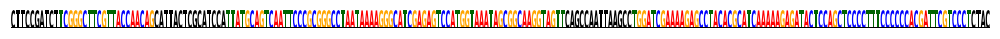

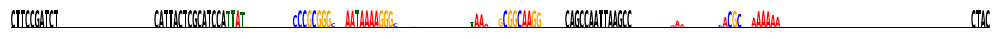

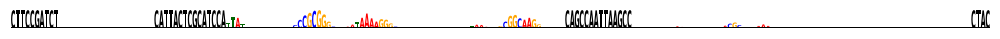

Test sequence 1:
 - Prediction (original) = 0.18
 - Predictions (scrambled) = [0.02, 0.06, 0.1, 0.17, 0.11, 0.05, 0.03, 0.06, 0.03, 0.05, 0.05, 0.11, 0.13, 0.06, 0.05, 0.03, 0.02, 0.02, 0.08, 0.11, 0.11, 0.05, 0.1, 0.07, 0.11, 0.03, 0.14, 0.37, 0.07, 0.02, 0.25, 0.3]


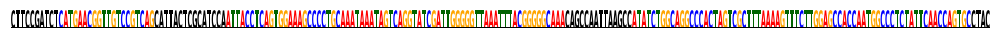

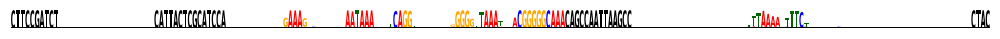

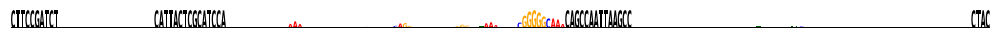

Test sequence 2:
 - Prediction (original) = 0.78
 - Predictions (scrambled) = [0.42, 0.69, 0.51, 0.73, 0.44, 0.27, 0.6, 0.96, 0.66, 0.46, 0.83, 0.88, 0.36, 0.63, 0.23, 0.28, 0.38, 0.58, 0.51, 0.77, 0.66, 0.65, 0.96, 0.47, 0.5, 0.74, 0.53, 0.28, 0.44, 0.28, 0.8, 0.4]


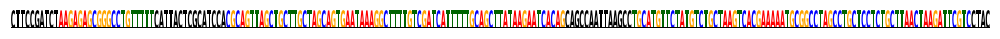

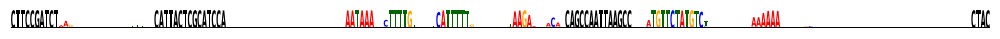

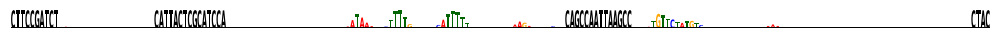

Test sequence 3:
 - Prediction (original) = 0.15
 - Predictions (scrambled) = [0.19, 0.17, 0.31, 0.24, 0.08, 0.15, 0.08, 0.2, 0.05, 0.11, 0.67, 0.12, 0.12, 0.23, 0.27, 0.08, 0.04, 0.07, 0.06, 0.29, 0.13, 0.22, 0.02, 0.14, 0.18, 0.09, 0.06, 0.05, 0.19, 0.16, 0.27, 0.05]


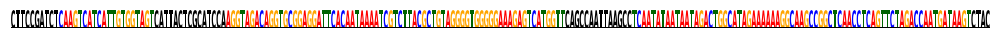

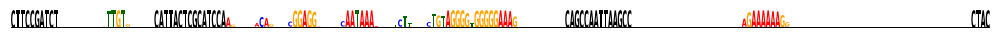

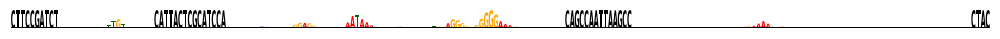

Test sequence 4:
 - Prediction (original) = 0.27
 - Predictions (scrambled) = [0.21, 0.1, 0.48, 0.81, 0.12, 0.75, 0.14, 0.27, 0.25, 0.08, 0.1, 0.03, 0.04, 0.42, 0.56, 0.15, 0.36, 0.67, 0.38, 0.7, 0.18, 0.75, 0.13, 0.33, 0.38, 0.24, 0.21, 0.06, 0.55, 0.38, 0.26, 0.49]


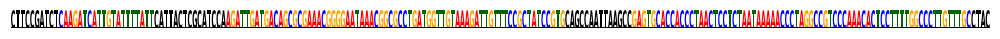

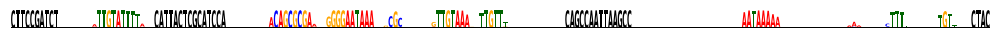

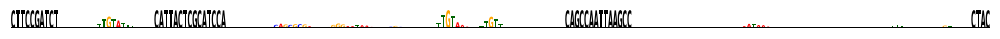

Test sequence 5:
 - Prediction (original) = 0.67
 - Predictions (scrambled) = [0.84, 0.88, 0.19, 0.64, 0.54, 0.59, 0.93, 0.74, 0.88, 0.72, 0.58, 0.3, 0.68, 0.71, 0.85, 0.18, 0.52, 0.47, 0.6, 0.75, 0.74, 0.77, 0.86, 0.86, 0.93, 0.87, 0.69, 0.77, 0.49, 0.63, 0.92, 0.17]


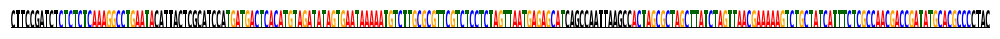

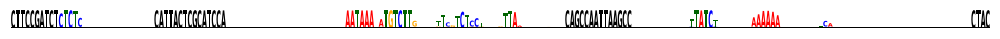

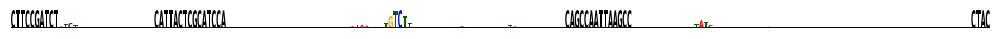

Test sequence 6:
 - Prediction (original) = 0.93
 - Predictions (scrambled) = [0.82, 0.77, 0.98, 0.85, 0.91, 0.7, 0.93, 0.94, 0.79, 0.84, 0.97, 0.83, 0.94, 0.97, 0.86, 0.9, 0.82, 0.98, 0.78, 0.78, 0.93, 0.84, 0.97, 0.88, 0.98, 0.92, 0.84, 0.88, 0.96, 0.78, 0.77, 0.92]


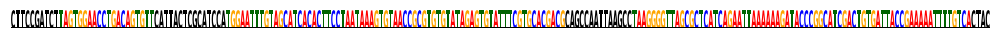

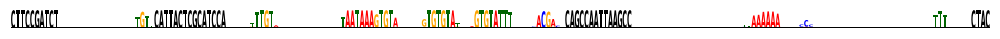

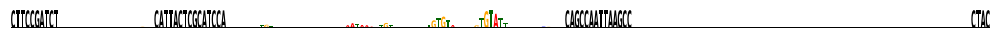

Test sequence 7:
 - Prediction (original) = 0.84
 - Predictions (scrambled) = [0.11, 0.42, 0.71, 0.17, 0.53, 0.22, 0.68, 0.72, 0.18, 0.34, 0.39, 0.59, 0.39, 0.79, 0.21, 0.58, 0.06, 0.42, 0.22, 0.29, 0.24, 0.24, 0.22, 0.41, 0.8, 0.66, 0.33, 0.44, 0.8, 0.61, 0.39, 0.52]


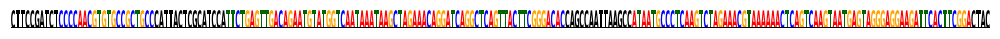

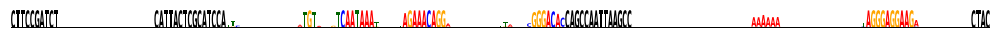

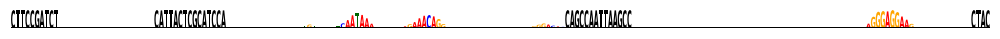

Test sequence 8:
 - Prediction (original) = 0.6
 - Predictions (scrambled) = [0.31, 0.84, 0.29, 0.38, 0.73, 0.79, 0.5, 0.36, 0.21, 0.85, 0.54, 0.53, 0.87, 0.33, 0.1, 0.25, 0.63, 0.63, 0.74, 0.75, 0.99, 0.68, 0.81, 0.78, 0.45, 0.54, 0.34, 0.87, 0.49, 0.8, 0.34, 0.33]


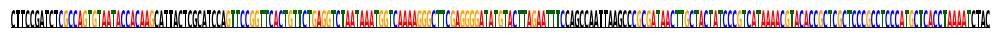

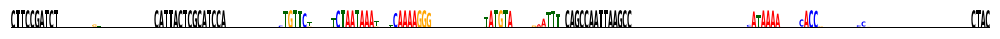

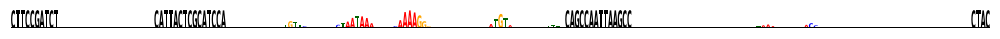

Test sequence 9:
 - Prediction (original) = 0.65
 - Predictions (scrambled) = [0.89, 0.63, 0.13, 0.76, 0.83, 0.77, 0.55, 0.54, 0.74, 0.77, 0.41, 0.94, 0.23, 0.22, 0.47, 0.94, 0.54, 0.57, 0.39, 0.79, 0.57, 0.21, 0.55, 0.74, 0.28, 0.58, 0.28, 0.43, 0.54, 0.71, 0.77, 0.33]


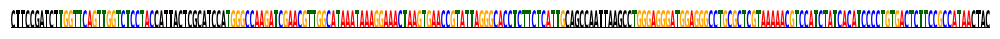

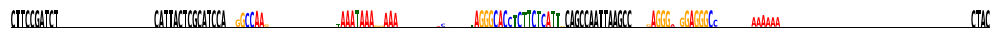

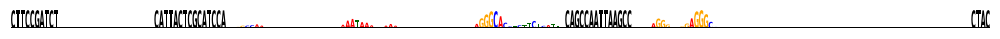

In [9]:
#Visualize a few reconstructed sequence patterns

plot_examples = np.arange(10).tolist()
save_examples = []

importance_scores_test *= sequence_mask[None, None, :, None]

for test_ix in plot_examples :
    
    print("Test sequence " + str(test_ix) + ":")
    
    y_test_hat_ref = predictor.predict(x=[x_test[test_ix:test_ix+1, ...]], batch_size=1)[0, 0]
    y_test_hat = predictor.predict(x=[sample_test[test_ix, ...]], batch_size=32)[:32, 0].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    save_figs = False
    if save_examples is not None and test_ix in save_examples :
        save_figs = True
    
    plot_dna_logo(x_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence")
    plot_dna_logo(pwm_test[test_ix, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm")
    plot_dna_importance_scores(importance_scores_test[test_ix, 0, :, :].T, encoder.decode(x_test[test_ix, 0, :, :]), figsize=(14, 0.65), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=205, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores")
    

Grabbing frame 0...
Grabbing frame 10...
Grabbing frame 20...
Grabbing frame 30...
Grabbing frame 40...
Grabbing frame 50...
Grabbing frame 60...
Grabbing frame 70...
Grabbing frame 80...
Grabbing frame 90...
Grabbing frame 100...
Grabbing frame 110...
Grabbing frame 120...
Grabbing frame 130...
Grabbing frame 140...
Grabbing frame 150...
Grabbing frame 160...
Grabbing frame 170...
Grabbing frame 180...
Grabbing frame 190...
Grabbing frame 200...
Grabbing frame 210...
Grabbing frame 220...
Grabbing frame 230...
Grabbing frame 240...
Grabbing frame 250...
Grabbing frame 260...
Grabbing frame 270...
Grabbing frame 280...
Grabbing frame 290...
Grabbing frame 300...
Grabbing frame 310...
Grabbing frame 320...
Grabbing frame 330...
Grabbing frame 340...
Grabbing frame 350...
Grabbing frame 360...
Grabbing frame 370...
Grabbing frame 380...
Grabbing frame 390...
Grabbing frame 400...
Grabbing frame 410...
Grabbing frame 420...
Grabbing frame 430...
Grabbing frame 440...
Grabbing frame 450...

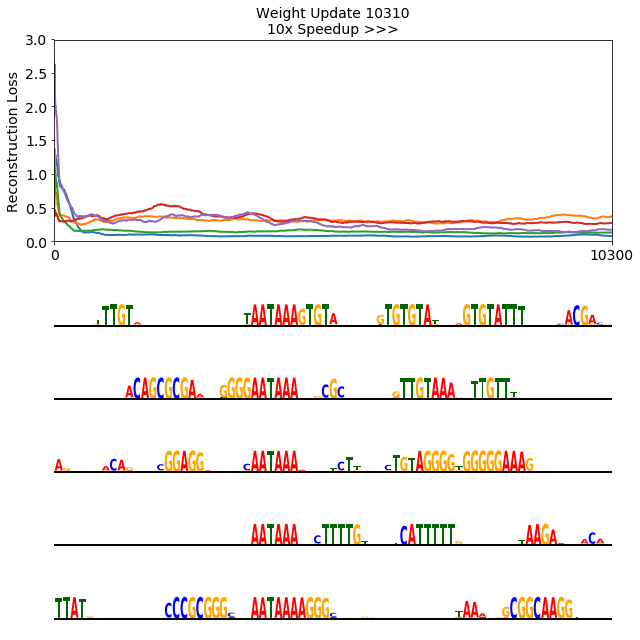

In [9]:
#Unpickle train history and animate GIF

train_history = pickle.load(open(save_dir + '/' + model_name + '_train_history.pickle', 'rb'))['train_history']

example_indices = [0, 2, 3, 4, 6]

animate_apa_examples(train_history, example_indices, model_name, sequence_template)
